# Setting up the environment

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import Imputer
import copy
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.tools.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# The refugee dataset is being imported as a dataframe

In [48]:
data = pd.read_excel(r'G:\MS sem 2\Data science lab\datasets\filtered_one.xlsx',index_col='Date', parse_dates=['Date'])
data

,Arrivals to Italy,Arrivals to Greek Islands,Departures to mainland Greece,Arrivals to fYRoM,Arrivals to Serbia,Arrivals to Croatia,Arrivals to Hungary,Arrivals to Slovenia,Arrivals to Austria
Date,,,,,,,,,
2015-10-01,343,2631,2409,4370,5900.0,4344,3667.0,0.0,4550
2015-10-02,0,4055,1215,5853,3700.0,5546,4897.0,0.0,2700
2015-10-03,128,6097,4480,4202,3700.0,6086,6056.0,NaN,7100
2015-10-04,62,4763,1513,5181,4250.0,5065,5925.0,0.0,5800
2015-10-05,0,5909,7833,4282,3250.0,6338,5952.0,0.0,6100
2015-10-06,2001,6496,6707,4156,2650.0,6370,6000.0,NaN,5800
2015-10-07,1010,3734,4886,7816,4350.0,4446,6103.0,0.0,5861
2015-10-08,0,4295,5349,7663,4650.0,7798,4583.0,6.0,4229
2015-10-09,572,5695,2631,6107,6550.0,8201,7215.0,0.0,6700


# Analysis of the data 

Text(0.5,0,'Months')

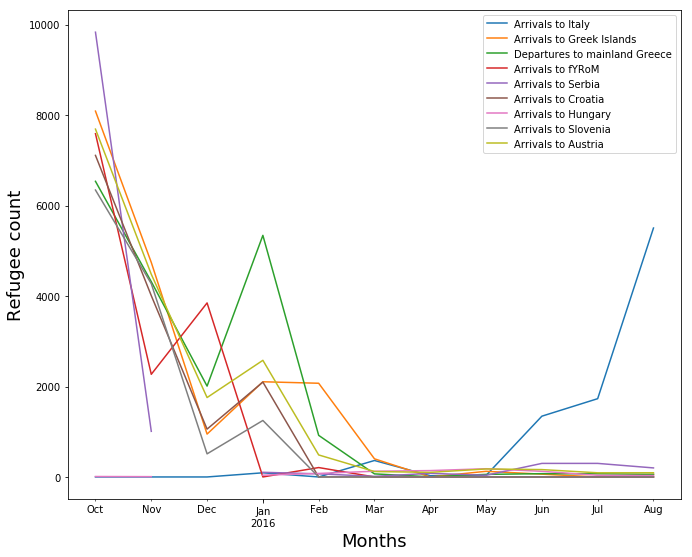

In [3]:
rcParams['figure.figsize'] = 11, 9
data.asfreq('M').plot()
plt.ylabel('Refugee count', fontsize=18)
plt.xlabel('Months', fontsize=18)

# Interpolation to fill the missing values

In [10]:
# To check if there are any null values in the dataset
data.isnull().sum()   

Arrivals to Italy                0
Arrivals to Greek Islands        0
Departures to mainland Greece    0
Arrivals to fYRoM                0
Arrivals to Serbia               1
Arrivals to Croatia              0
Arrivals to Hungary              1
Arrivals to Slovenia             4
Arrivals to Austria              0
dtype: int64

# Linear Interpolation

In [4]:
def linear_interpolation (country):
    linear_interpolated_data = country.interpolate(method='linear')
    return (linear_interpolated_data)

# IDW Interpolation

In [10]:
def idw_interpolation_k_factor(country,factor):
    
    dates = country.index.to_series()
    arrivals = country.iloc[:]
    location = []
    loc = []

    ind = pd.Index(arrivals)
    
    cnt = 0

    boolean_value = arrivals.isna()
    
    for i in boolean_value:
        if i==True: cnt+=1
        
    if cnt>0:
            location = np.append(loc, ind.get_loc(np.nan))

            weights = []
            indexes = list(range(len(dates)))

            for k in range (0, len(location)):
                numerator = []
                shift_index = indexes[:] - (location[k])

                for i in range(0,len(shift_index)-1):
                    if shift_index[i]<0:
                        shift_index[i]=shift_index[i]*(-1)


                for i in range(0,len(shift_index)):
                    if shift_index[i]!=0:
                        shift_index[i] = 1 / (shift_index[i]**factor)


                for i in range(0,len(shift_index)):
                    if shift_index[i]!=0:
                        numerator = np.append(numerator, (ind[i] * shift_index[i]))
                    else:
                         numerator = np.append(numerator,0)

                denominator = shift_index
                weights.append(np.nansum(numerator) // np.nansum(denominator))

   
            
            count = 0
            for item in location:
                if(count < len(weights)):
                    country.iloc[int(item)] = weights[count]
                    count += 1

    return country

# Interpolating the missing data using IDW interpolation

Three countries have no entries in the dataset. Hence IDW interpolation is used to fill those missing values. 

In [49]:
interpolated_data = copy.deepcopy(data)
for country in data.columns:
    interpolated_data[country] = idw_interpolation_k_factor(data[country], 1) # k-value is taken as 1. 

In [19]:
interpolated_data.isnull().sum()   # All the missing data is being filled with approximated values using IDW interpolation.

Arrivals to Italy                0
Arrivals to Greek Islands        0
Departures to mainland Greece    0
Arrivals to fYRoM                0
Arrivals to Serbia               0
Arrivals to Croatia              0
Arrivals to Hungary              0
Arrivals to Slovenia             0
Arrivals to Austria              0
dtype: int64

# Comparison of IDW and linear interpolation using RMSE error

Here evaluation procedure is carried out by manually removing two random entries from the dataset for all the countries. Then, 
IDW and Linear Interpolation techniques are applied to check the accuracy of both the methods.

In [45]:
rmse_data = copy.deepcopy(interpolated_data)
original_data = copy.deepcopy(interpolated_data)
rmse_IDW = []
rmse_linear = []
idw_interpolated_data = copy.deepcopy(interpolated_data)

for item in interpolated_data.columns:
    rmse_data[item]['2015-10-10'] = np.nan
    rmse_data[item]['2016-09-12'] = np.nan
rmse_data_2 = copy.deepcopy(rmse_data)

for item in rmse_data.columns:
    idw_interpolated_data[item] = idw_interpolation_k_factor(rmse_data[item],1)

linear_interpolated_data = linear_interpolation(rmse_data_2)

for item in data.columns:
    rmse_IDW.append(math.sqrt(mean_squared_error(original_data[item], idw_interpolated_data[item])))
    rmse_linear.append(math.sqrt(mean_squared_error(original_data[item], linear_interpolated_data[item])))

    
countries = interpolated_data.columns
models = ['IDW', 'Linear']
df_results = pd.DataFrame(columns = models, index = countries)


count = 0
for item in countries:
    df_results.loc[item] = rmse_IDW[count], rmse_linear[count]
    count+= 1

print ('Average RMSE values for all countries : \n\n IDW interpolation = %f \n Linear interpolation = %f' %(np.mean(df_results['IDW']), np.mean(df_results['Linear'])))
df_results

Average RMSE values for all countries : 

 IDW interpolation = 72.580963 
 Linear interpolation = 68.230322


,IDW,Linear
Arrivals to Italy,109.249,119.861
Arrivals to Greek Islands,32.239,43.6753
Departures to mainland Greece,98.8236,83.4443
Arrivals to fYRoM,10.4942,45.2779
Arrivals to Serbia,10.7502,74.0959
Arrivals to Croatia,135.624,49.1944
Arrivals to Hungary,216.533,18.5771
Arrivals to Slovenia,16.9141,43.9018
Arrivals to Austria,22.6015,136.045


# Time Series decomposition for Slovenia

The original time series can be decomposed into Trend, Seasonal and Residual components to observe the stationarity of the time series data

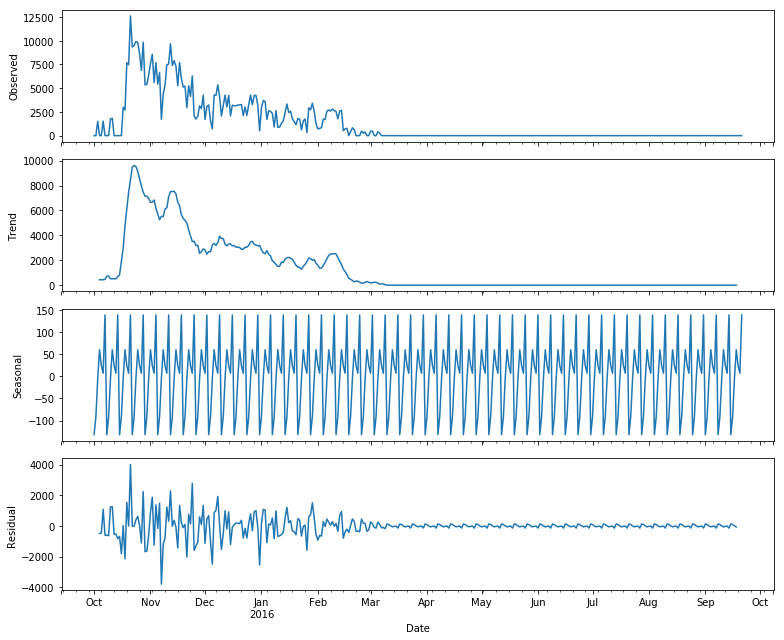

In [57]:
rcParams['figure.figsize'] = 11, 9
data_Slovenia = data[['Arrivals to Slovenia']]
decomposed_Slovenia = sm.tsa.seasonal_decompose(data_Slovenia)
figure = decomposed_Slovenia.plot()
plt.show()

# Augmented Dickey Fuller test

In [50]:
def dickey_fuller(country):
    
    dftest = adfuller(country, autolag='AIC')
    df = pd.Series(dftest[0:4], index=['Test Statistic','P-Value','#Lags used','Number of observation used'])
    for key,value in dftest[4].items():
        df['Critical values (%s)'%key] = value
    print ('Dickey Fuller test results: \n')
    print (df)

# Function to check stationarity

In [51]:
def check_stationarity(country):
    
    rol_mean = country.rolling('90D').mean()
    rol_std = country.rolling('90D').std()
    country.plot()
    rol_mean.plot()
    rol_std.plot()
    plt.legend(['Original series','Rolling mean','Rolling standard deviation'])
    plt.title('Rolling mean and rolling standard deviation plot')
    plt.show()

# To check stationarity of the time series (for Italy)

The country Italy is stationary time series since p-value < 0.05.
Rolling Mean and Standard deviation plot is also constant with respect to time.

Dickey Fuller test results: 

Test Statistic               -8.677227e+00
P-Value                       4.382857e-14
#Lags used                    1.000000e+00
Number of observation used    3.550000e+02
Critical values (1%)         -3.448906e+00
Critical values (5%)         -2.869716e+00
Critical values (10%)        -2.571126e+00
dtype: float64


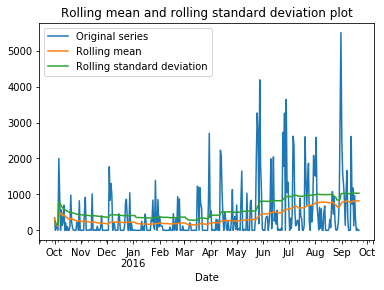

In [52]:
dickey_fuller(interpolated_data['Arrivals to Italy'])
check_stationarity(interpolated_data['Arrivals to Italy'])

# Trend and Seasonal plot for Italy

From Trend and Seasonal plot, we can observe that the country Italy exhibits some trend patterns. However, it can be confirmed from the Augmented Dickey Fuller test and Rolling mean and standard deviation plot that Italy is stationary time series. 

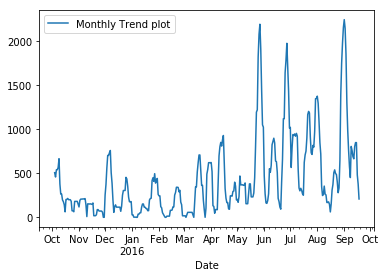

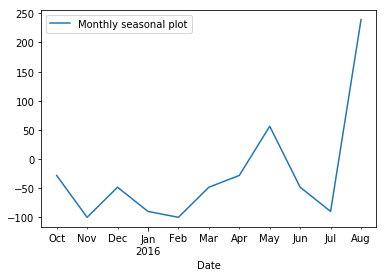

In [62]:
decomposed_data = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Italy'])
decomposed_data.trend.plot()
plt.legend(['Monthly Trend plot'])
plt.show()
decomposed_data.seasonal.asfreq('M').plot()
plt.legend(['Monthly seasonal plot'])
plt.show()

# Non-stationary time series (For the country Slovenia)

The country Slovenia is non-stationary time series since p-value > 0.05. Rolling Mean and Standard deviation plot is also varying with respect to time.

Dickey Fuller test results: 

Test Statistic                 -1.464423
P-Value                         0.551032
#Lags used                     17.000000
Number of observation used    339.000000
Critical values (1%)           -3.449788
Critical values (5%)           -2.870104
Critical values (10%)          -2.571332
dtype: float64


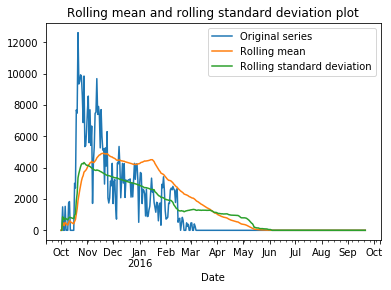

In [53]:
dickey_fuller(interpolated_data['Arrivals to Slovenia'])
check_stationarity(interpolated_data['Arrivals to Slovenia'])

# Trend and Seasonal plot for "Slovenia" before performing Difference Transform

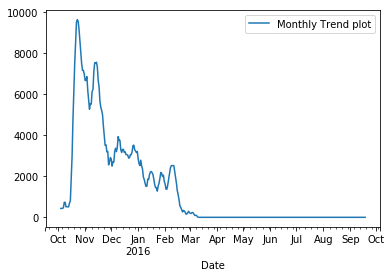

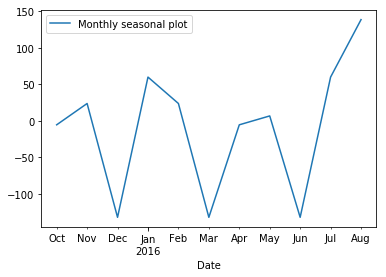

In [63]:
decomposed_data = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Slovenia'])
decomposed_data.trend.plot()
plt.legend(['Monthly Trend plot'])
plt.show()
decomposed_data.seasonal.asfreq('M').plot()
plt.legend(['Monthly seasonal plot'])
plt.show()

# Difference Transform

In [54]:
def difference_transform(country):
    
    de_trend = country.diff(1)
    de_trend[:1] = country[:1]
    de_trend_season = de_trend.diff(7)
    de_trend_season[:7] = de_trend[:7]
    return de_trend_season

# Difference Transform for non-stationary data for the remaining 8 countries

In [55]:
# Creating a new dataframe for storing differenced series having same column names and index.
differenced_series = pd.DataFrame(columns = interpolated_data.columns, index = interpolated_data.index)



# Difference Transform is done for all the 8 countries except "Italy"

for country in interpolated_data.columns:
    if country != 'Arrivals to Italy': 
        differenced_series[country] = difference_transform(interpolated_data[country])
    else:
        differenced_series[country] = interpolated_data[country]

In [15]:
differenced_series  # Results of 1st order Differenced series.

,Arrivals to Italy,Arrivals to Greek Islands,Departures to mainland Greece,Arrivals to fYRoM,Arrivals to Serbia,Arrivals to Croatia,Arrivals to Hungary,Arrivals to Slovenia,Arrivals to Austria
Date,,,,,,,,,
2015-10-01,343,2631.0,2409.0,4370.0,5900.0,4344.0,3667.0,0.0,4550.0
2015-10-02,0,1424.0,-1194.0,1483.0,-2200.0,1202.0,1230.0,0.0,-1850.0
2015-10-03,128,2042.0,3265.0,-1651.0,0.0,540.0,1159.0,1497.0,4400.0
2015-10-04,62,-1334.0,-2967.0,979.0,550.0,-1021.0,-131.0,-1497.0,-1300.0
2015-10-05,0,1146.0,6320.0,-899.0,-1000.0,1273.0,27.0,0.0,300.0
2015-10-06,2001,587.0,-1126.0,-126.0,-600.0,32.0,48.0,1529.0,-300.0
2015-10-07,1010,-2762.0,-1821.0,3660.0,1700.0,-1924.0,103.0,-1529.0,61.0
2015-10-08,0,-2070.0,-1946.0,-4523.0,-5600.0,-992.0,-5187.0,6.0,-6182.0
2015-10-09,572,-24.0,-1524.0,-3039.0,4100.0,-799.0,1402.0,-6.0,4321.0


# Trend and Seasonal plot for "Slovenia" after Difference Transform

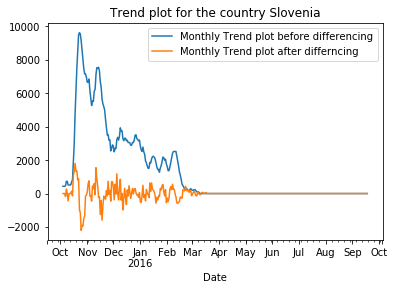

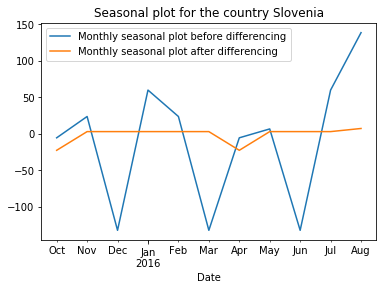

In [59]:
# As shown below, the trend and seasonal plot for Slovenia can be drawn for the rest of the countries to analyze the trend and 
# seasonality before and after differencing.



 # Time series decomposition into trend, seasonality and Residual parts.
decomposed_data = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Slovenia'])
decomposed_data_diff = sm.tsa.seasonal_decompose(differenced_series['Arrivals to Slovenia'])


# Extracting trend patterns from the decomposed series.
decomposed_data.trend.plot()
decomposed_data_diff.trend.plot()
plt.title('Trend plot for the country Slovenia')
plt.legend(['Monthly Trend plot before differencing', 'Monthly Trend plot after differncing'])
plt.show()


# Extracting seasonal patterns from the decomposed series.
decomposed_data.seasonal.asfreq('M').plot()
decomposed_data_diff.seasonal.asfreq('M').plot()
plt.title('Seasonal plot for the country Slovenia')
plt.legend(['Monthly seasonal plot before differencing', 'Monthly seasonal plot after differencing'])
plt.show()

# Rolling Mean and Standard deviation test and Dickey fuller test for Slovenia after applying Difference Transform


It can be seen that from Dickey fuller test, p-value has reduced form 0.55 to 3.6*e-10 which is less than 0.05. Additionally,
from the Rolling mean and standard deviation plot, we can observe that the mean is reduced to zero and the deviation has also
reduced from the original non-stationary series.


Dickey Fuller test results: 

Test Statistic               -7.126442e+00
P-Value                       3.609971e-10
#Lags used                    1.700000e+01
Number of observation used    3.390000e+02
Critical values (1%)         -3.449788e+00
Critical values (5%)         -2.870104e+00
Critical values (10%)        -2.571332e+00
dtype: float64


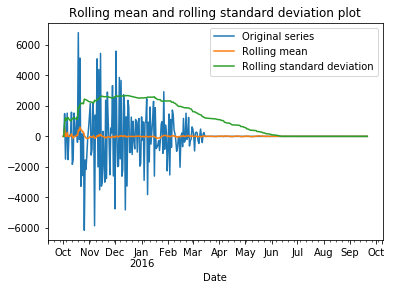

In [24]:
dickey_fuller(differenced_series['Arrivals to Slovenia'])
check_stationarity(differenced_series['Arrivals to Slovenia'])

# Trend and Seasonal plot for "Slovenia" after 2nd order Difference Transform

2nd order Differencing is performed in order to check if we can stationarize it further. However there is no significant improvement in the data. Hence 2nd order differencing is discarded.

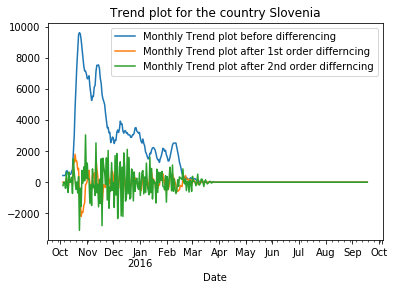

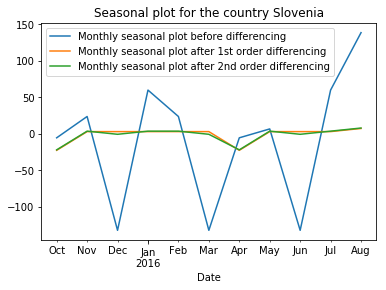

In [60]:
slovenia_order_2 = difference_transform(differenced_series['Arrivals to Slovenia'])


 # Time series decomposition into trend, seasonality and Residual parts.
decomposed_data = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Slovenia'])
decomposed_data_diff_1 = sm.tsa.seasonal_decompose(differenced_series['Arrivals to Slovenia'])
decomposed_data_diff_2 = sm.tsa.seasonal_decompose(slovenia_order_2)


# Extracting trend patterns from the decomposed series.
decomposed_data.trend.plot()
decomposed_data_diff_1.trend.plot()
decomposed_data_diff_2.trend.plot()
plt.title('Trend plot for the country Slovenia')
plt.legend(['Monthly Trend plot before differencing', 'Monthly Trend plot after 1st order differncing', 'Monthly Trend plot after 2nd order differncing'])
plt.show()


# Extracting seasonal patterns from the decomposed series.
decomposed_data.seasonal.asfreq('M').plot()
decomposed_data_diff_1.seasonal.asfreq('M').plot()
decomposed_data_diff_2.seasonal.asfreq('M').plot()
plt.title('Seasonal plot for the country Slovenia')
plt.legend(['Monthly seasonal plot before differencing', 'Monthly seasonal plot after 1st order differencing','Monthly seasonal plot after 2nd order differencing'])
plt.show()

# Heat Map model to check cross-correlation

From the heat map model we can observe the cross correlations from lag 1 to 4 between the countries <b> Arrivals to Greek Islands </b> and <b> Departures to Mainland Greece. </b> It can be observed that there is a significant cross-correlation of <b>41%</b> between Mainland Greece of lag 2 and Greek Islands of lag 1.

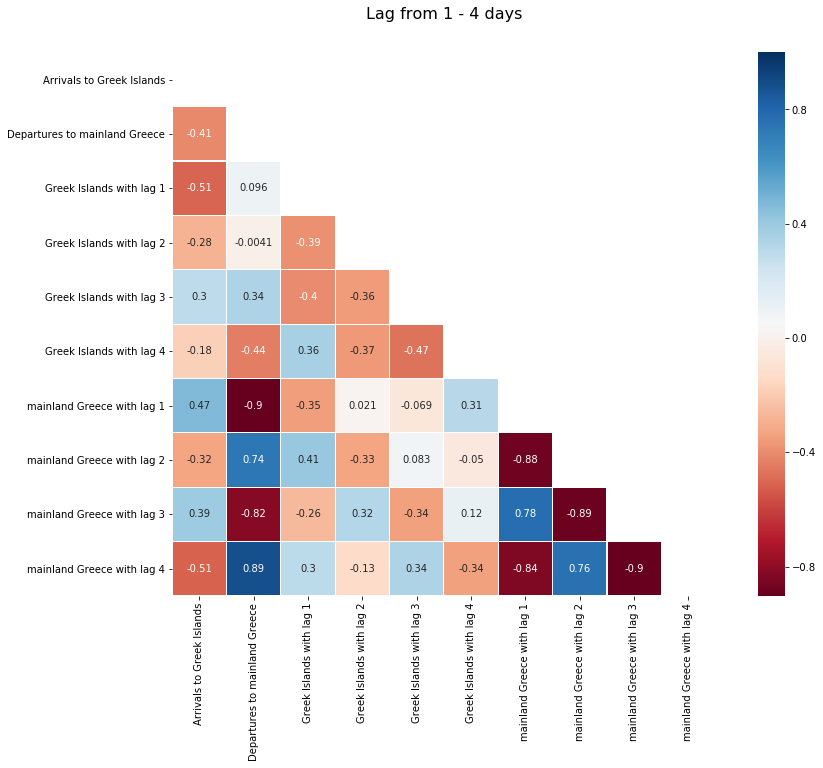

In [69]:
def cross_correlation_heatmap (name1, name2):
    country = differenced_series[[name1,name2]]
    for i in range(1,5):
        tt = differenced_series[name1][train_size:].shift(i)
        col = str(name1[12:]) + ' with lag ' + str(i)
        country[col] = tt

    for j in range(1,5):
        tt = differenced_series[name2][train_size:].shift(j)
        col = str(name2[14:]) +' with lag ' + str(j)
        country[col] = tt

    country = country.dropna()
    correlation = country.corr()
    
    colormap = plt.cm.RdBu
    plt.figure(figsize=(15,10))
    plt.title(u'Lag from 1 - 4 days', y=1.05, size=16)

    mask = np.zeros_like(correlation.corr())
    mask[np.triu_indices_from(mask)] = True

    svm = sns.heatmap(correlation.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)
    
    
    
    
train_size = int(len(differenced_series)*0.8)
cross_correlation_heatmap ('Arrivals to Greek Islands', 'Departures to mainland Greece')

# Correlations for all the countries

In [54]:
def find_correlations(data):
    c_original = []
    countries = data.columns    # To fetch all the 9 country names.
    max_country_list = []
    maximum = 0
    df = pd.DataFrame(columns = countries, index = countries)

    for item in countries:
        for item2 in countries:
            if (item != item2):
                correlation = interpolated_data[item][:68].corr(interpolated_data[item2][:68])
                df[item][item2] = correlation
                c_original.append(correlation)
                
                
                # To find which countries having maximum correlation between them
                if (correlation > maximum): 
                    maximum = correlation
                    max_country_list = [item, item2]

                    
    print ('Maximum correlation is: %f for the countries %s ' % (maximum, max_country_list))
    
    # Correlation between the same countries will be 1
    df.fillna(1)
    return df
    
    
find_correlations (interpolated_data)

Maximum correlation is: 0.877923 for the countries ['Arrivals to fYRoM', 'Arrivals to Serbia'] 


,Arrivals to Italy,Arrivals to Greek Islands,Departures to mainland Greece,Arrivals to fYRoM,Arrivals to Serbia,Arrivals to Croatia,Arrivals to Hungary,Arrivals to Slovenia,Arrivals to Austria
Arrivals to Italy,NaN,0.100851,0.0544528,-0.214827,-0.28528,-0.164656,0.148275,-0.164466,-0.0697113
Arrivals to Greek Islands,0.100851,NaN,0.484729,0.254353,0.266691,0.236453,0.0657016,0.192842,0.201476
Departures to mainland Greece,0.0544528,0.484729,NaN,0.444472,0.393103,0.184778,-0.0583298,0.249425,0.125019
Arrivals to fYRoM,-0.214827,0.254353,0.444472,NaN,0.877923,0.559777,-0.0224065,0.337199,0.250382
Arrivals to Serbia,-0.28528,0.266691,0.393103,0.877923,NaN,0.634506,-0.0771409,0.417456,0.289225
Arrivals to Croatia,-0.164656,0.236453,0.184778,0.559777,0.634506,NaN,0.0936095,0.536873,0.587598
Arrivals to Hungary,0.148275,0.0657016,-0.0583298,-0.0224065,-0.0771409,0.0936095,NaN,-0.659235,0.0795126
Arrivals to Slovenia,-0.164466,0.192842,0.249425,0.337199,0.417456,0.536873,-0.659235,NaN,0.404803
Arrivals to Austria,-0.0697113,0.201476,0.125019,0.250382,0.289225,0.587598,0.0795126,0.404803,NaN


## Adding a new column 'Total Balkan count'

In order to check the total number of refugees passing through the Balkon route, we have hypothesized that the total Balkon count on a particular day to be the sum of the refugee inflow count across all the countries for that corresponding day. This is achieved by adding a new column called <b>Total Balkon count</b>.

In [68]:
def add_total_balkon(country):
    total = []
    for j in range(0, len(country)):
        sum = 0
        for item in country.columns:
            sum += country[item].iloc[j]
        total.append(sum)
    return total
        
balkon_data = interpolated_data.copy()        
balkon_data['Total Balkon'] = add_total_balkon(interpolated_data)
balkon_data

,Arrivals to Italy,Arrivals to Greek Islands,Departures to mainland Greece,Arrivals to fYRoM,Arrivals to Serbia,Arrivals to Croatia,Arrivals to Hungary,Arrivals to Slovenia,Arrivals to Austria,Total Balkon
Date,,,,,,,,,,
2015-10-01,343,2631,2409,4370,5900.0,4344,3667.0,0.0,4550,28214.0
2015-10-02,0,4055,1215,5853,3700.0,5546,4897.0,0.0,2700,27966.0
2015-10-03,128,6097,4480,4202,3700.0,6086,6056.0,1497.0,7100,39346.0
2015-10-04,62,4763,1513,5181,4250.0,5065,5925.0,0.0,5800,32559.0
2015-10-05,0,5909,7833,4282,3250.0,6338,5952.0,0.0,6100,39664.0
2015-10-06,2001,6496,6707,4156,2650.0,6370,6000.0,1529.0,5800,41709.0
2015-10-07,1010,3734,4886,7816,4350.0,4446,6103.0,0.0,5861,38206.0
2015-10-08,0,4295,5349,7663,4650.0,7798,4583.0,6.0,4229,38573.0
2015-10-09,572,5695,2631,6107,6550.0,8201,7215.0,0.0,6700,43671.0
